# Visualize model content
## Setup
### Import packages

In [1]:
import textwrap
from collections import defaultdict
import re

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from rbc_gem_utils import (
    ROOT_PATH,
    CURATION_PATH,
    RESULTS_PATH,
    INTERIM_PATH,
    DATABASE_PATH,
    GEM_NAME,
    get_annotation_df,
    read_rbc_model,
    show_versions,
    split_string,
    build_string,
)
from rbc_gem_utils.visualization import cmap_map

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Load RBC-GEM model

In [2]:
# Use XML for groups
model = read_rbc_model(filetype="xml")
model

Name,RBC_GEM
Memory address,146457b10
Number of metabolites,2008
Number of reactions,2977
Number of genes,718
Number of groups,77
Objective expression,1.0*NaKt - 1.0*NaKt_reverse_db47e
Compartments,"cytosol, extracellular space"


## Categorize reactions by KEGG Pathways

In [3]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
imagetype = "png"
transparent = True
save_figures = True

### Load pathway mappings

In [4]:
df_pathways = pd.read_csv(
    f"{ROOT_PATH}{CURATION_PATH}/subsystems.tsv", sep="\t", index_col=0, dtype=str
)
df_pathways = df_pathways.fillna("").reset_index()
all_figure_data["PathwayMapping"] = df_pathways.copy()
# Group "Metabolism of other amino acids" with amino acids rather than treat as "other"
df_pathways["category"] = df_pathways["category"].replace(
    "Metabolism of other amino acids", "Amino acid metabolism"
)
df_pathways

,name,category,kegg.pathway.name,kegg.pathway,notes
0,"Alanine, aspartate and glutamate metabolism",Amino acid metabolism,"Alanine, aspartate and glutamate metabolism",hsa00250,
1,Arginine and proline metabolism,Amino acid metabolism,Arginine and proline metabolism,hsa00330,
2,Cysteine and methionine metabolism,Amino acid metabolism,Cysteine and methionine metabolism,hsa00270,
3,"Glycine, serine and threonine metabolism",Amino acid metabolism,"Glycine, serine and threonine metabolism",hsa00260,
4,Histidine metabolism,Amino acid metabolism,Histidine metabolism,hsa00340,
...,...,...,...,...,...
72,Sulfur metabolism,Reactive species,Sulfur metabolism,hsa00920,"Categorized as energy metabolism in KEGG, but ..."
73,Aminoacyl-tRNA biosynthesis,Translation,Aminoacyl-tRNA biosynthesis,has00970,
74,"Transport, extracellular",Transport reactions,,,Representative subsystem for all transport rea...
75,Azathioprine and 6-mercaptopurine metabolism,Xenobiotics biodegradation and metabolism,Drug metabolism - other enzymes,hsa00983,"Subnetwork of KEGG pathway ""Drug metabolism - ..."


### Visualization options

In [5]:
# Categories that should be excluded from the figure
categories_to_exclude = {"Pseudoreactions", "Model total"}
# Main categories in figure and abbreviations, all unmapped categories are mapped to "Other"
categories_to_keep = {
    "Amino acid metabolism": mpl.cm.spring,
    "Carbohydrate metabolism": mpl.cm.Greens,
    "Lipid metabolism": mpl.cm.Blues,
    "Metabolism of cofactors and vitamins": mpl.cm.summer,
    "Nucleotide metabolism": mpl.cm.winter,
    "Reactive species": mpl.cm.Reds,
    "Transport reactions": mpl.cm.Purples,
    "Other": mpl.cm.gray_r,
}
use_abbrevs = True
abbrevs = {
    "Amino acid metabolism": "A",
    "Carbohydrate metabolism": "C",
    "Lipid metabolism": "L",
    "Metabolism of cofactors and vitamins": "V",
    "Nucleotide metabolism": "N",
    "Reactive species": "R",
    "Transport reactions": "T",
    "Other": "O",
}
barsize = 0.8
fontsize = 12
cmax = 0.8
cmin = 0.15


colormaps_normal = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x * 1, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)
colormaps_light = dict(
    zip(
        categories_to_keep,
        [
            cmap_map(lambda x: x / 2 + 0.5, categories_to_keep[k])(cmax)
            for k in categories_to_keep
        ],
    )
)

#### Create tables and individual figures

In [6]:
data = defaultdict(dict)
all_reactions = set()
df_cat_subsystems = df_pathways.groupby("category")["name"].agg(lambda x: list(x))
for category, subsystem_list in df_cat_subsystems.items():
    if category not in categories_to_keep and category not in categories_to_exclude:
        category = "Other"

    if category not in data:
        data[category] = {"Reactions": set(), "Metabolites": set(), "Genes": set()}
    reactions = [
        reaction
        for group in model.groups.get_by_any(subsystem_list)
        for reaction in group.members
    ]
    for reaction in reactions:
        all_reactions.update([reaction])
        data[category]["Reactions"].update([reaction])
        data[category]["Metabolites"].update(reaction.metabolites)
        data[category]["Genes"].update(reaction.genes)

data["Model total"] = {
    "Reactions": model.reactions,
    "Metabolites": model.metabolites,
    "Genes": model.genes,
}
df_data = pd.DataFrame(
    {
        key: {k: len(x) for k, x in value_dict.items()}
        for key, value_dict in data.items()
    }
).T.sort_index()

# Remove columns to exlcude:
for to_exclude in categories_to_exclude:
    del data[to_exclude]
df_data = df_data.sort_values("Reactions", ascending=False)
if use_abbrevs:
    df_data["abbrevs"] = abbrevs
all_figure_data["General"] = df_data.copy()
df_data

,Reactions,Metabolites,Genes,abbrevs
Model total,2977,2008,718,NaN
Transport reactions,813,808,138,T
Lipid metabolism,710,738,104,L
Pseudoreactions,422,540,0,NaN
Amino acid metabolism,246,237,90,A
Other,201,317,189,O
Carbohydrate metabolism,196,184,128,C
Nucleotide metabolism,167,144,106,N
Metabolism of cofactors and vitamins,135,166,64,V
Reactive species,87,106,35,R


### Subsystems

In [7]:
df_subsystem_data = defaultdict(dict)
reactions = set()
idx = 0
for category, subsystem_list in df_cat_subsystems.items():
    if category in categories_to_exclude:
        continue
    if category not in categories_to_keep:
        category = "Other"

    for group in model.groups.get_by_any(subsystem_list):
        df_subsystem_data[idx]["name"] = group.name
        df_subsystem_data[idx]["category"] = category
        df_subsystem_data[idx]["size"] = len(group.members)
        reactions.update(group.members)
        idx += 1
df_subsystem_data = pd.DataFrame.from_dict(df_subsystem_data, orient="index")
# QC check: Ensure mappings worked correctly and there is a color per category
# QC check Total number of reactions (excluding pseudoreactions) match sum of the group sizes
assert (
    len(model.reactions.query(lambda x: not x.subsystem == "Pseudoreactions"))
    == df_subsystem_data["size"].sum()
)
df_subsystem_data = df_subsystem_data.sort_values(
    by=["category", "size"], ascending=[True, False]
).reset_index(drop=True)
all_figure_data["Subsytem Sizes"] = df_subsystem_data.copy()

# Set colors
df_subsystem_data_color = df_subsystem_data.set_index("name")
colors = {}
for category, (names, size) in (
    df_subsystem_data.groupby(["category"])
    .agg({"name": lambda x: list(x), "size": "size"})
    .iterrows()
):
    colors.update(
        dict(
            zip(
                names, categories_to_keep[category](np.linspace(cmax - 0.1, cmin, size))
            )
        )
    )
df_subsystem_data_color["color"] = colors
df_subsystem_data_color = df_subsystem_data_color.reset_index(drop=False)
df_subsystem_data_color

,name,category,size,color
0,"Phenylalanine, tyrosine and tryptophan metabolism",Amino acid metabolism,121,"[1.0, 0.7019607843137254, 0.29803921568627456,..."
1,Cysteine and methionine metabolism,Amino acid metabolism,38,"[1.0, 0.6392156862745098, 0.36078431372549025,..."
2,Arginine and proline metabolism,Amino acid metabolism,30,"[1.0, 0.5764705882352941, 0.42352941176470593,..."
3,Glutathione metabolism,Amino acid metabolism,17,"[1.0, 0.5176470588235293, 0.48235294117647065,..."
4,"Glycine, serine and threonine metabolism",Amino acid metabolism,15,"[1.0, 0.4549019607843137, 0.5450980392156863, ..."
...,...,...,...,...
71,N-glycan metabolism,Other,1,"[0.8509803921568627, 0.8509803921568627, 0.850..."
72,Reactive species formation and detoxification,Reactive species,47,"[0.8503344867358708, 0.14686658977316416, 0.13..."
73,Hemoglobin binding and degradation,Reactive species,28,"[0.9867128027681661, 0.5116493656286044, 0.386..."
74,Sulfur metabolism,Reactive species,12,"[0.9945713187235679, 0.8505497885428681, 0.786..."


In [8]:
df_category_data = df_subsystem_data.groupby("category")["size"].sum()
assert df_category_data.nunique() == len(categories_to_keep)
if use_abbrevs:
    df_category_data = pd.concat(
        (df_category_data, pd.Series(abbrevs, name="abbrev")), axis=1
    )
    df_category_data.index.name = "category"
df_category_data = df_category_data.sort_index(ascending=True).reset_index(drop=False)
all_figure_data["Category Sizes"] = df_data.copy()
# # # Add colors to table
df_category_data_color = df_category_data.set_index("category")
df_category_data_color["color"] = {
    key: tuple(value(cmax)) for key, value in categories_to_keep.items()
}
df_category_data_color = df_category_data_color.reset_index(drop=False)
df_category_data_color

,category,size,abbrev,color
0,Amino acid metabolism,246,A,"(1.0, 0.8, 0.19999999999999996, 1.0)"
1,Carbohydrate metabolism,196,C,"(0.0823529411764706, 0.49803921568627446, 0.23..."
2,Lipid metabolism,710,L,"(0.09019607843137256, 0.39294117647058824, 0.6..."
3,Metabolism of cofactors and vitamins,135,V,"(0.8, 0.9, 0.4, 1.0)"
4,Nucleotide metabolism,167,N,"(0.0, 0.8, 0.6, 1.0)"
5,Other,201,O,"(0.19999999999999996, 0.19999999999999996, 0.1..."
6,Reactive species,87,R,"(0.7364705882352941, 0.08, 0.10117647058823528..."
7,Transport reactions,813,T,"(0.3811764705882353, 0.25176470588235295, 0.60..."


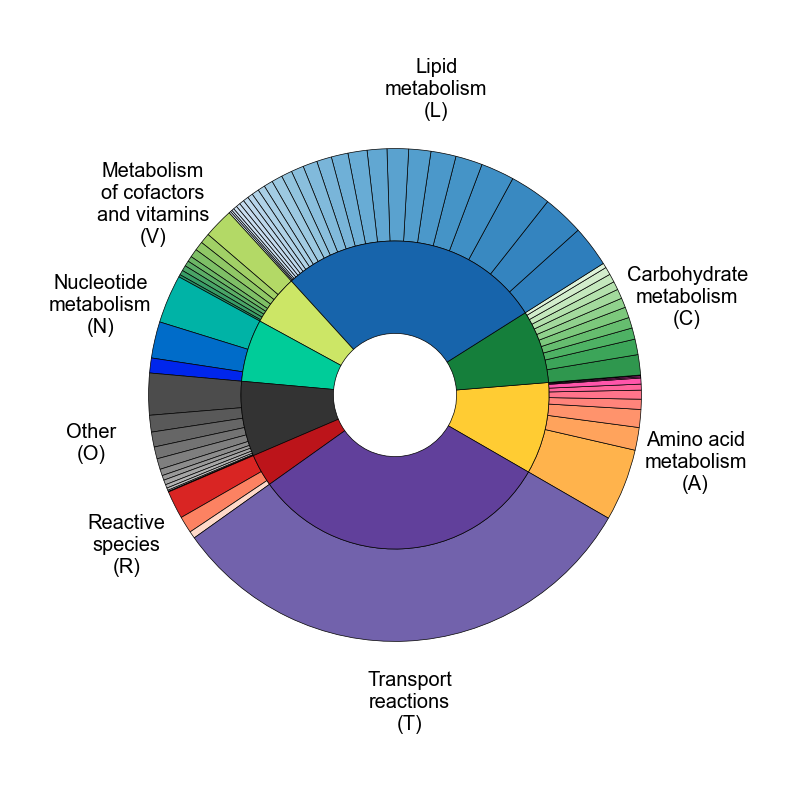

In [9]:
df_ring0, df_ring1 = df_category_data_color, df_subsystem_data_color

fig_ring, ax_ring = plt.subplots(1, 1, figsize=(8, 8))

wedgesize = 0.3
radius = 0.5
startangle = -30
ring_idx = 1
linewidth = 0.5
edgecolor = "k"
wedges, labels = ax_ring.pie(
    df_subsystem_data_color["size"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_subsystem_data_color["color"].values,
    # labels=df_subsystem_data_color["name"].values,
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": fontsize},
    startangle=startangle,
)

ring_idx = 0
wedges, labels = ax_ring.pie(
    df_category_data_color["size"].values,
    radius=radius + (ring_idx * wedgesize),
    colors=df_category_data_color["color"].values,
    labels=[
        "\n".join(
            textwrap.wrap(x.strip(), 12)
            + [f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else ""]
        ).strip()
        for x in df_category_data_color["category"].values
    ],
    wedgeprops=dict(
        width=wedgesize, linewidth=linewidth, edgecolor=edgecolor, clip_on=False
    ),
    textprops={"fontsize": fontsize * 1.2, "va": "center", "ha": "center"},
    startangle=startangle,
    labeldistance=2,
)

fig_ring.tight_layout()
if save_figures:
    fig_ring.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelA.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

#### Transporter categorized

In [10]:
database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"

df_tcdb_data = pd.read_csv(
    f"{database_dirpath}/TCDB_{GEM_NAME}.tsv",
    sep="\t",
    index_col=0,
    dtype=str,
).fillna("")
df_tcdb_data = df_tcdb_data.loc[
    :, ["tcdb", "subfamily", "family", "subclass", "class", "name"]
].drop_duplicates()

groupby_key = "class"
groupby_regex = {
    "class": r"^\w+",
    "subclass": r"^\w+\W\w+",
    "family": r"^\w+\W\w+\W\w+",
    "subfamily": r"^\w+\W\w+\W\w+\W\w+",
    "tcdb": r"^\w+\W\w+\W\w+\W\w+\W\w+",
}[groupby_key]

tcdb_mappings = {
    "class": {
        "1": "Channels/Pores",
        "2": "Electrochemical Potential-driven Transporters",
        "3": "Primary Active Transporters",
        "4": "Group Translocators",
        "5": "Transmembrane Electron Carriers",
        "8": "Accessory Factors Involved in Transport",
        "9": "Incompletely Characterized Transport Systems",
    },
    "subclass": {},
    "family": df_tcdb_data.set_index("family")["name"]
    .replace("", float("nan"))
    .dropna()
    .drop_duplicates()
    .to_dict(),
    "subfamily": {},
}[groupby_key]

df_tcdb_data

,tcdb,subfamily,family,subclass,class,name
0,3.A.1.211.14,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
1,3.A.1.211.10,3.A.1.211,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
2,3.A.1.201.1,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
3,3.A.1.201.3,3.A.1.201,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
4,3.A.1.210.6,3.A.1.210,3.A.1,3.A,3,The ATP-binding Cassette (ABC) Superfamily
...,...,...,...,...,...,...
144,1.A.4.2.8,1.A.4.2,1.A.4,1.A,1,The Transient Receptor Potential Ca2+/Cation C...
145,9.A.24.1.17,9.A.24.1,9.A.24,9.A,9,
146,3.A.16.1.1,3.A.16.1,3.A.16,3.A,3,The Endoplasmic Reticular Retrotranslocon (ER-...
147,1.B.8.1.12,1.B.8.1,1.B.8,1.B,1,The Mitochondrial and Plastid Porin (MPP) Family


In [11]:
transport_reactions = model.reactions.query(
    lambda x: x in data["Transport reactions"]["Reactions"]
)

df_transport_reactions = pd.DataFrame(
    {"genes": {r.id: set([g.id for g in list(r.genes)]) for r in transport_reactions}}
)
df_transport_reactions.index.name = "reactions"
df_transport_reactions = df_transport_reactions.explode("genes").reset_index(drop=False)


df_model_genes = get_annotation_df(model.genes, ["ncbigene", "tcdb"]).rename(
    {"id": "genes"}, axis=1
)
df_model_genes = df_model_genes[df_model_genes["tcdb"].notna()]
df_model_genes["tcdb"] = df_model_genes["tcdb"].apply(
    lambda x: split_string(x) if isinstance(x, str) else x
)
df_model_genes = df_model_genes.explode("tcdb")
df_model_genes = df_model_genes.sort_values(by="tcdb").reset_index(drop=True)

df_transport_reactions = (
    df_transport_reactions.merge(
        df_model_genes, left_on="genes", right_on="genes", how="left"
    )
    .merge(df_tcdb_data, left_on="tcdb", right_on="tcdb", how="left")
    .drop_duplicates()
)


df_transport_reactions = df_transport_reactions.loc[
    :, ["reactions", "genes", "tcdb", "subfamily", "family", "subclass", "class"]
]
df_transport_reactions = df_transport_reactions.drop_duplicates()
df_transport_reactions = df_transport_reactions.copy()

df_transport_reactions[groupby_key] = (
    df_transport_reactions["tcdb"].str.findall(groupby_regex).explode()
)
df_transport_reactions[groupby_key] = df_transport_reactions[groupby_key].fillna(
    "Unclassified"
)
df_transport_reactions = pd.merge(
    df_transport_reactions.groupby(groupby_key)[["reactions", "genes"]].agg(
        lambda x: x.dropna().nunique()
    ),
    df_transport_reactions.groupby(groupby_key)[["reactions", "genes"]].agg(
        lambda x: build_string(x.dropna().unique())
    ),
    left_index=True,
    right_index=True,
    how="left",
    suffixes=("", ".ids"),
)
all_figure_data[f"Transporters_{groupby_key}"] = df_transport_reactions.copy()
df_transport_reactions = df_transport_reactions.drop(
    labels=[c for c in df_transport_reactions.columns if c.endswith(".ids")], axis=1
).astype(int)
df_transport_reactions

,reactions,genes
class,,
1,31,27
2,499,57
3,67,30
4,68,2
5,5,2
8,403,6
9,97,7
Unclassified,224,11


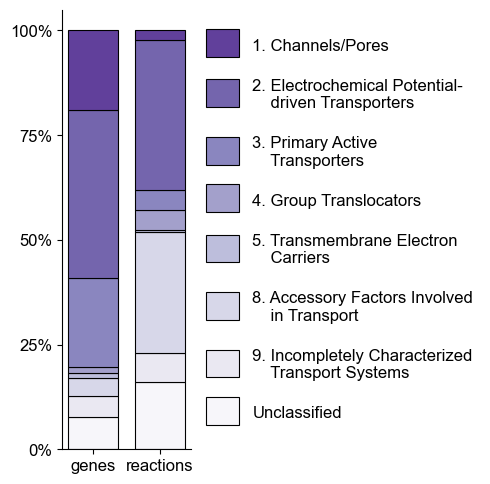

In [12]:
df = df_transport_reactions.copy()

barsize = 0.75
edgecolor = "black"
edgewidth = 0.8
columns = ["genes", "reactions"]
labels = df.index


totals = df.sum(axis=0)
df = round(df / totals * 100, 3)
df = df[::-1].T
df = df.loc[columns]

color_dict = dict(
    zip(
        labels,
        categories_to_keep["Transport reactions"](np.linspace(cmax, 0.05, len(labels))),
    )
)

fig_transport, ax_transport = plt.subplots(1, 1, figsize=(5, 5))
sns.despine(fig_transport)
offset = np.zeros(len(df.index))
for idx, (label, series) in enumerate(df.items()):
    rects = ax_transport.bar(
        series.index,
        series.values,
        barsize,
        bottom=offset,
        color=color_dict[label],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values
    # if idx == len(df.columns) - 1:
    #     ax.bar_label(rects, labels=totals.values, label_type='edge', color="black",  fmt='{:,.0f}', padding=1)


ticks = np.linspace(0, 100, 5)
ax_transport.set_yticks(ticks, [f"{v:.0f}%" for v in ticks])
ax_transport.set_yticklabels(
    ax_transport.get_yticklabels(), fontdict={"size": fontsize}
)
ax_transport.xaxis.set_tick_params(labelsize=fontsize)
legend = ax_transport.legend(
    handles=[
        mpl.patches.Patch(
            facecolor=color,
            label=tcdb_mappings.get(label, label),
            edgecolor=edgecolor,
            linewidth=edgewidth,
        )
        for label, color in color_dict.items()
    ],
    labels=[
        "\n    ".join(textwrap.wrap(f"{label}. " + tcdb_mappings.get(label, label), 29))
        if label != "Unclassified"
        else label
        for label, color in color_dict.items()
    ],
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    frameon=False,
    fontsize=fontsize,
    labelspacing=1.5,
)
for patch in legend.get_patches():
    patch.set_height(20)
    patch.set_y(-5)
fig_transport.tight_layout()
if save_figures:
    fig_transport.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelB.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Reaction content

In [13]:
df_reactions = defaultdict(dict)

for category in categories_to_keep:
    reactions = data[category]["Reactions"]
    gene_associated = set([rxn for rxn in reactions if rxn.gene_reaction_rule])
    known_spontaneous = set(
        [
            rxn
            for rxn in reactions
            if int(rxn.annotation.get("spontaneous", 0)) and rxn not in gene_associated
        ]
    )
    unknown = set(
        [
            rxn
            for rxn in reactions
            if not rxn in gene_associated and not rxn in known_spontaneous
        ]
    )
    df_reactions[category]["Gene associated"] = len(gene_associated)
    df_reactions[category]["Spontaneous"] = len(known_spontaneous)
    df_reactions[category]["Unknown"] = len(unknown)
    df_reactions[category]["Total"] = len(reactions)

    df_reactions[category]["Gene associated.ids"] = build_string(
        sorted([x.id for x in gene_associated])
    )
    df_reactions[category]["Spontaneous.ids"] = build_string(
        sorted([x.id for x in known_spontaneous])
    )
    df_reactions[category]["Unknown.ids"] = build_string(
        sorted([x.id for x in unknown])
    )

df_reactions = pd.DataFrame.from_dict(df_reactions).T
if use_abbrevs:
    df_reactions["abbrevs"] = abbrevs
# QC check to ensure no reactions are missing
assert (
    df_reactions[["Gene associated", "Spontaneous", "Unknown"]].sum(axis=1)
    == df_reactions["Total"]
).all()
assert df_reactions["Total"].sum() == len(
    model.reactions.query(lambda x: not x.subsystem == "Pseudoreactions")
)
df_reactions = df_reactions.sort_values(by="Total", ascending=True)

all_figure_data["Reactions"] = df_reactions.copy()
df_reactions = df_reactions.drop(
    labels=[c for c in df_reactions.columns if c.endswith(".ids") or c == "abbrevs"],
    axis=1,
).astype(int)
df_reactions

,Gene associated,Spontaneous,Unknown,Total
Reactive species,58,20,9,87
Metabolism of cofactors and vitamins,107,10,18,135
Nucleotide metabolism,150,9,8,167
Carbohydrate metabolism,179,5,12,196
Other,177,19,5,201
Amino acid metabolism,170,35,41,246
Lipid metabolism,542,69,99,710
Transport reactions,666,0,147,813


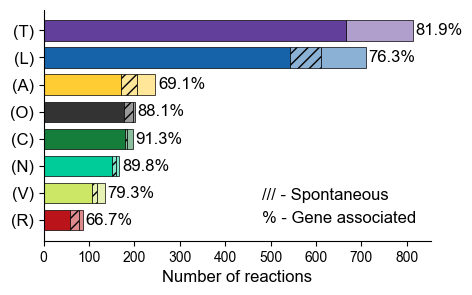

In [14]:
df = df_reactions.copy()

percentage_col = "Gene associated"
only_total = False
colormaps_dict = {
    "Gene associated": colormaps_normal,
    "Spontaneous": colormaps_light,
    "Unknown": colormaps_light,
}
hatches_dict = {
    "Gene associated": None,
    "Spontaneous": "///",
    "Unknown": None,
}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_reactions, ax_rxns = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_reactions)

offset = np.zeros(len(df.index))
columns_to_plot = (
    ["Total"] if only_total else [col for col in df.columns if col != "Total"]
)
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_rxns.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_rxns.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_rxns.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=["/// - Spontaneous", f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_rxns.set_xlabel("Number of reactions", fontsize=fontsize)
ax_rxns.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_reactions.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelC.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Gene content

In [15]:
df_genes = defaultdict(dict)

for category in categories_to_keep:
    genes = data[category]["Genes"]
    # Genes that are not unique to one category
    shared = set(
        [
            x
            for x in genes
            if any(
                [
                    set(x.reactions).intersection(data[cat]["Reactions"])
                    for cat in data.keys()
                    if cat != category
                ]
            )
        ]
    )
    unique = set([x for x in genes if not x in shared])
    df_genes[category]["Shared"] = len(shared)
    df_genes[category]["Unique"] = len(unique)
    df_genes[category]["Total"] = len(genes)

    df_genes[category]["Shared.ids"] = build_string(sorted([x.id for x in shared]))
    df_genes[category]["Unique.ids"] = build_string(sorted([x.id for x in unique]))

# To DataFrame
df_genes = pd.DataFrame.from_dict(df_genes).T
if use_abbrevs:
    df_genes["abbrevs"] = abbrevs
# QC check to ensure no genes are missing
assert (df_genes[["Shared", "Unique"]].sum(axis=1) == df_genes["Total"]).all()
df_genes = df_genes.sort_values(by="Total", ascending=True)
all_figure_data["Genes"] = df_genes.copy()
df_genes = df_genes.drop(
    labels=[c for c in df_genes.columns if c.endswith(".ids") or c == "abbrevs"], axis=1
).astype(int)
df_genes

,Shared,Unique,Total
Reactive species,28,7,35
Metabolism of cofactors and vitamins,26,38,64
Amino acid metabolism,47,43,90
Lipid metabolism,36,68,104
Nucleotide metabolism,28,78,106
Carbohydrate metabolism,33,95,128
Transport reactions,2,136,138
Other,31,158,189


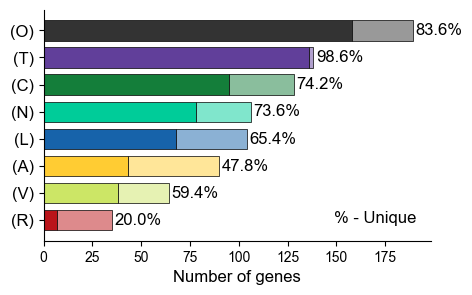

In [16]:
df = df_genes.copy()
percentage_col = "Unique"
only_total = False
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_genes, ax_genes = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_genes)

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_genes.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_genes.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_genes.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_genes.set_xlabel("Number of genes", fontsize=fontsize)
ax_genes.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_genes.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelD.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

### Metabolite content

In [17]:
df_metabolites = defaultdict(dict)

for category in categories_to_keep:
    metabolites = data[category]["Metabolites"]
    # metabolites = set([met for met in metabolites if met.compartment != "e"])
    # Genes that are not unique to one category
    shared = set(
        [
            x
            for x in metabolites
            if any(
                [
                    set(x.reactions).intersection(data[cat]["Reactions"])
                    for cat in data.keys()
                    if cat != category
                ]
            )
        ]
    )
    unique = set([x for x in metabolites if not x in shared])
    df_metabolites[category]["Shared"] = len(shared)
    df_metabolites[category]["Unique"] = len(unique)
    df_metabolites[category]["Total"] = len(metabolites)

    df_metabolites[category]["Shared.ids"] = build_string(
        sorted([x.id for x in shared])
    )
    df_metabolites[category]["Unique.ids"] = build_string(
        sorted([x.id for x in unique])
    )

# To DataFrame
df_metabolites = pd.DataFrame.from_dict(df_metabolites).T
if use_abbrevs:
    df_metabolites["abbrevs"] = abbrevs
# QC check to ensure no genes are missing
assert (
    df_metabolites[["Shared", "Unique"]].sum(axis=1) == df_metabolites["Total"]
).all()
df_metabolites = df_metabolites.sort_values(by="Total", ascending=True)
all_figure_data["Metabolites"] = df_metabolites.copy()
df_metabolites = df_metabolites.drop(
    labels=[c for c in df_metabolites.columns if c.endswith(".ids") or c == "abbrevs"],
    axis=1,
).astype(int)
df_metabolites

,Shared,Unique,Total
Reactive species,66,40,106
Nucleotide metabolism,81,63,144
Metabolism of cofactors and vitamins,92,74,166
Carbohydrate metabolism,90,94,184
Amino acid metabolism,114,123,237
Other,96,221,317
Lipid metabolism,229,509,738
Transport reactions,399,409,808


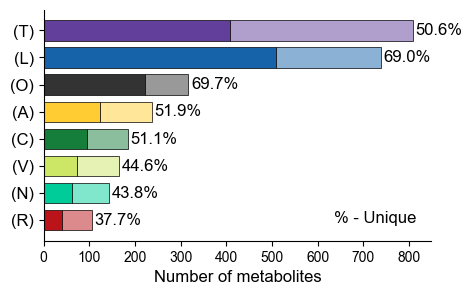

In [18]:
df = df_metabolites.copy()

percentage_col = "Unique"
only_total = False
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)

fig_metabolites, ax_mets = plt.subplots(1, 1, figsize=barchart_figsize)
sns.despine(fig_metabolites)

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_mets.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_mets.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_mets.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
ax_mets.set_xlabel("Number of metabolites", fontsize=fontsize)
ax_mets.yaxis.set_tick_params(labelsize=fontsize)
if save_figures:
    fig_metabolites.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelE.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )

## Export Figures and Data

In [19]:
print(all_figure_data.keys())
with pd.ExcelWriter(
    f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContentOverviewData.xlsx"
) as writer:
    for sheet_name, df in all_figure_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

dict_keys(['PathwayMapping', 'General', 'Subsytem Sizes', 'Category Sizes', 'Transporters_class', 'Reactions', 'Genes', 'Metabolites'])


### Aggregate Panels for visualization

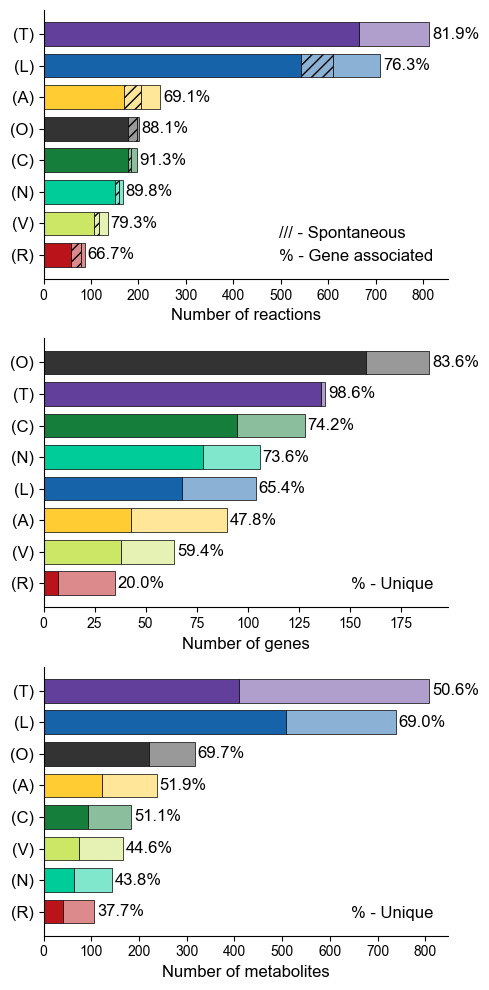

In [20]:
fig, axes = plt.subplots(3, 1, figsize=(5, 10))
sns.despine(fig)
(ax_rxns, ax_genes, ax_mets) = axes.flatten()


only_total = False
barsize = 0.75
edgecolor = "black"
edgewidth = 0.5
padding = 2
barchart_figsize = (5, 3)


## Reaction content
df = df_reactions.copy()
percentage_col = "Gene associated"
colormaps_dict = {
    "Gene associated": colormaps_normal,
    "Spontaneous": colormaps_light,
    "Unknown": colormaps_light,
}
hatches_dict = {
    "Gene associated": None,
    "Spontaneous": "///",
    "Unknown": None,
}

offset = np.zeros(len(df.index))
columns_to_plot = (
    ["Total"] if only_total else [col for col in df.columns if col != "Total"]
)
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_rxns.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_rxns.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_rxns.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=["/// - Spontaneous", f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
attribute_type = "reactions"
ax_rxns.set_xlabel(f"Number of {attribute_type}", fontsize=fontsize)
ax_rxns.yaxis.set_tick_params(labelsize=fontsize)

## Gene content
df = df_genes.copy()
percentage_col = "Unique"
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_genes.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_genes.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_genes.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
attribute_type = "genes"
ax_genes.set_xlabel(f"Number of {attribute_type}", fontsize=fontsize)
ax_genes.yaxis.set_tick_params(labelsize=fontsize)

## Metabolite content
df = df_metabolites.copy()
percentage_col = "Unique"
colormaps_dict = {
    "Unique": colormaps_normal,
    "Shared": colormaps_light,
    "Total": colormaps_normal,
}
hatches_dict = {}

offset = np.zeros(len(df.index))
columns_to_plot = ["Total"] if only_total else ["Unique", "Shared"]
for idx, (label, series) in enumerate(df[columns_to_plot].items()):
    rects = ax_mets.barh(
        [
            f"({abbrevs.get(x)})" if abbrevs.get(x) and use_abbrevs else x
            for x in series.index
        ],
        series.values,
        height=barsize,
        hatch=hatches_dict.get(label, None),
        left=offset,
        label=f"% - {percentage_col}",
        color=[colormaps_dict.get(label, colormaps_normal)[k] for k in series.index],
        edgecolor=edgecolor,
        linewidth=edgewidth,
    )
    offset += series.values

percents = [
    "{:,.1f}%".format(v) for v in 100 * (df[percentage_col] / df["Total"]).values
]
ax_mets.bar_label(
    rects,
    labels=percents,
    label_type="edge",
    color="black",
    padding=padding,
    fontsize=fontsize,
)
ax_mets.legend(
    handles=[
        mpl.patches.Patch(color="white"),
        mpl.patches.Patch(color="white"),
    ],
    labels=[f"% - {percentage_col}"],
    frameon=False,
    loc="lower right",
    fontsize=fontsize,
)
attribute_type = "metabolites"
ax_mets.set_xlabel(f"Number of {attribute_type}", fontsize=fontsize)
ax_mets.yaxis.set_tick_params(labelsize=fontsize)

fig.tight_layout()
if save_figures:
    fig.savefig(
        f"{ROOT_PATH}{RESULTS_PATH}/content/ModelContent_PanelCDE.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;